In [ ]:
# -*- coding: utf-8 -*-
"""
Average PS time series inside GeoJSON polygons (MintPy-friendly I/O)

Dependencies:
    pip install mintpy h5py numpy pandas geopandas shapely matplotlib

Notes:
- Uses mintpy.utils.readfile.read() for all MintPy files (timeseries, tc, mask).
- For polygon selection, needs lon/lat of pixel centers:
    * First tries to read from geometry*.h5 (longitude/latitude).
    * If not found, reconstructs lon/lat by bilinear interpolation from
      lat_ref1..4 / lon_ref1..4 attributes in the timeseries file.
"""
import h5py
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from mintpy.utils import readfile

# ----------------- USER SETTINGS -----------------
TS_PATH   = Path("/insar-data/Miaplpy_Tocantins/miaplpy/network_delaunay_4/timeseries_ERA5_demErr.h5")
TC_PATH   = Path("/insar-data/Miaplpy_Tocantins/miaplpy/network_delaunay_4/temporalCoherence.h5")
MASK_PS   = Path("/insar-data/Miaplpy_Tocantins/miaplpy/maskPS.h5")

# If you have a MintPy geometry file with lon/lat, you may point to it here (optional).
# If left as None, the script will auto-try common names next to TS_PATH, else fall back to corner refs.
GEOMETRY_PATH = "/insar-data/Miaplpy_Tocantins/miaplpy/network_delaunay_4/inputs/geometryRadar.h5"  # e.g., Path("/insar-data/.../geometryGeo.h5") or geometryRadar.h5

# GeoJSON with your polygons (WGS84 lon/lat)
POLYGONS_GEOJSON = Path("/insar-data/Miaplpy_Tocantins/miaplpy/Toc_TSA.geojson")
POLYGON_NAME_FIELD = "Name"   # (optional) attribute in GeoJSON to use as series label, else "poly_<i>"

COH_THR = None   # set to None to disable temporal coherence filtering
UNITS   = "cm"   # "m" or "mm"

SAVE_FIG = Path("/insar-data/Miaplpy_Tocantins/miaplpy/avg_TS_by_polygon_geojson_2.png")   # set to None to skip
SAVE_CSV = Path("/insar-data/Miaplpy_Tocantins/miaplpy/avg_TS_by_polygon_geojson_2.csv")   # set to None to skip
LINEWIDTH = 2.0
# -------------------------------------------------


# ----------------- HELPERS -----------------
def read_ts_mintpy(ts_path: Path):
    """
    Robust time-series reader:
      1) Read data with MintPy (ts3d: (T,R,C), atr).
      2) Read '/date' directly via h5py and parse strictly as YYYYMMDD.
      3) If '/date' missing, fall back to DATE_LIST / DATE_TIMES attrs.
      4) Validate count vs T and sort time axis if needed.
    Returns:
      ts3d (T,R,C) float32, dates (DatetimeIndex), atr (dict)
    """
    # 1) MintPy read for the data/attrs
    ts3d, atr = readfile.read(str(ts_path))           # typically (T, R, C)
    T = int(ts3d.shape[0])

    # 2) Try h5py on '/date' (source of truth per your info.py)
    dates = None
    with h5py.File(str(ts_path), "r") as f:
        if "date" in f:
            raw = f["date"][()]              # shape (T,), dtype likely '|S8'
        elif "/date" in f:                    # just in case
            raw = f["/date"][()]
        else:
            raw = None

    if raw is not None:
        arr = np.asarray(raw).ravel()
        # bytes -> str
        if arr.dtype.kind == "S":
            strs = [b.decode("ascii", "ignore").strip() for b in arr]
        else:
            # sometimes stored as numeric; force 'YYYYMMDD'
            strs = [f"{int(x):08d}" if isinstance(x, (np.integer, int)) else str(x).strip() for x in arr]

        # Prefer exact YYYYMMDD; if that fails, try generic then normalize
        try:
            if all(len(s) == 8 and s.isdigit() for s in strs):
                dates = pd.to_datetime(strs, format="%Y%m%d", errors="raise")
            else:
                # try generic then normalize to YYYYMMDD if needed
                try:
                    dates = pd.to_datetime(strs, errors="raise")
                except Exception:
                    norm = [s.replace("-", "").replace("/", "") for s in strs]
                    dates = pd.to_datetime(norm, format="%Y%m%d", errors="raise")
        except Exception as e:
            # If parsing somehow fails, we’ll fall back to attrs below
            dates = None

    # 3) Fallback to MintPy attributes if '/date' was absent or unreadable
    if dates is None:
        if "DATE_LIST" in atr and atr["DATE_LIST"]:
            dates = pd.to_datetime(atr["DATE_LIST"].split(), format="%Y%m%d", errors="raise")
        elif "DATE_TIMES" in atr and atr["DATE_TIMES"]:
            dates = pd.to_datetime(atr["DATE_TIMES"].split(), errors="raise")
        else:
            raise ValueError(
                "Could not read '/date' and no DATE_LIST / DATE_TIMES in attributes. "
                "Run `info.py` to confirm datasets."
            )

    # 4) Validate length and sort time axis if necessary
    if len(dates) != T:
        raise ValueError(f"Dates length {len(dates)} != T {T} in {ts_path}")

    order = np.argsort(dates.values)
    if not np.all(order == np.arange(T)):
        ts3d = ts3d[order, ...]
        dates = dates[order]

    return ts3d.astype(np.float32), pd.DatetimeIndex(dates), atr


def read_2d_mintpy(path: Path, candidates=("/mask", "/temporalCoherence", "temporalCoherence", "mask")):
    """Read a 2D dataset via MintPy readfile with name guessing."""
    # try default
    try:
        arr, _ = readfile.read(str(path))
        if arr.ndim == 2:
            return arr
    except Exception:
        pass
    # try candidates
    for name in candidates:
        try:
            arr, _ = readfile.read(str(path), datasetName=name)
            if arr.ndim == 2:
                return arr
        except Exception:
            continue
    raise RuntimeError(f"Could not read a 2D dataset from {path}")


def try_read_lonlat_from_geometry(geom_path: Path):
    """Try to read longitude/latitude (2D) from a MintPy geometry*.h5 file."""
    if geom_path is None or not Path(geom_path).exists():
        return None, None
    # common dataset names
    lon_candidates = ("longitude", "/longitude", "lon", "/lon")
    lat_candidates = ("latitude", "/latitude", "lat", "/lat")
    lon = lat = None
    for name in lon_candidates:
        try:
            lon, _ = readfile.read(str(geom_path), datasetName=name)
            break
        except Exception:
            continue
    for name in lat_candidates:
        try:
            lat, _ = readfile.read(str(geom_path), datasetName=name)
            break
        except Exception:
            continue
    if lon is not None and lat is not None and lon.ndim == 2 and lat.ndim == 2:
        return np.array(lon, dtype=np.float64), np.array(lat, dtype=np.float64)
    return None, None



def lonlat_from_corner_refs(ts_path: Path, T_R_C_shape):
    """
    Reconstruct lon/lat (R,C) by bilinear interpolation from lat_ref1..4 / lon_ref1..4.
    Chooses the most consistent corner assignment automatically.
    """
    _, R, C = T_R_C_shape
    # Read attrs with MintPy readfile (to get attrs consistently)
    _, atr = readfile.read(str(ts_path))  # we only need attrs here
    # Normalize keys to lowercase for convenience
    attrs = {k.lower(): v for k, v in atr.items()}
    try:
        lats = [float(attrs[f'lat_ref{i}']) for i in range(1, 5)]
        lons = [float(attrs[f'lon_ref{i}']) for i in range(1, 5)]
    except Exception as e:
        raise RuntimeError("lat_ref*/lon_ref* not found in timeseries attributes; "
                           "cannot reconstruct lon/lat without geometry*.h5") from e

    v = np.linspace(0.0, 1.0, R)[:, None]  # rows
    u = np.linspace(0.0, 1.0, C)[None, :]  # cols

    def bilinear(c00, c10, c01, c11):
        return ((1 - u) * (1 - v) * c00 +
                u * (1 - v) * c10 +
                (1 - u) * v * c01 +
                u * v * c11)

    def score_grid(LON, LAT):
        dlon_x = np.nanmedian(np.diff(LON, axis=1))
        dlat_y = np.nanmedian(np.diff(LAT, axis=0))
        flips_x = int(np.sum(np.sign(np.diff(LON, axis=1)) != np.sign(dlon_x)))
        flips_y = int(np.sum(np.sign(np.diff(LAT, axis=0)) != np.sign(dlat_y)))
        dlon_dy = np.nanmedian(np.diff(LON, axis=0))
        dlat_dx = np.nanmedian(np.diff(LAT, axis=1))
        det_sign = np.sign(dlon_x * dlat_y - dlon_dy * dlat_dx)
        return (flips_x + flips_y) + (0 if det_sign != 0 else 1000), abs(dlon_x) + abs(dlat_y)

    best = None
    corners = list(zip(lons, lats))  # (lon, lat)
    for perm in itertools.permutations(corners, 4):
        (lon00, lat00), (lon10, lat10), (lon01, lat01), (lon11, lat11) = perm
        LON = bilinear(lon00, lon10, lon01, lon11)
        LAT = bilinear(lat00, lat10, lat01, lat11)

        lon_ok = (min(lons) - 1.0) <= float(np.nanmin(LON)) <= float(np.nanmax(LON)) <= (max(lons) + 1.0)
        lat_ok = (min(lats) - 1.0) <= float(np.nanmin(LAT)) <= float(np.nanmax(LAT)) <= (max(lats) + 1.0)
        if not (lon_ok and lat_ok):
            continue

        score = score_grid(LON, LAT)
        if (best is None) or (score < best[0]):
            best = (score, (LON, LAT))

    if best is None:
        raise RuntimeError("Failed to pick a consistent corner assignment for lon/lat.")
    return best[1]


def load_polygons_geojson(path: Path):
    """Load polygons from GeoJSON (ensure EPSG:4326)."""
    gdf = gpd.read_file(path)
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)
    else:
        gdf = gdf.to_crs(epsg=4326)
    gdf = gdf[gdf.geometry.notna()].copy()
    gdf = gdf[gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
    gdf.reset_index(drop=True, inplace=True)
    return gdf

def rolling_median(x, win):
    """Rolling median with edge handling (centered window; uses nanmedian)."""
    x = np.asarray(x, dtype=float)
    n = x.size
    half = win // 2
    rm = np.full(n, np.nan)
    for i in range(n):
        i0 = max(0, i - half)
        i1 = min(n, i + half + 1)
        rm[i] = np.nanmedian(x[i0:i1])
    return rm

def apply_smoothing_filter(series, window=5, method='gaussian'):
    """
    Apply smoothing filter to make time series smoother.
    
    Parameters:
    - series: input time series (1D array)
    - window: window size for smoothing
    - method: smoothing method ('moving_avg', 'gaussian', 'savgol')
    
    Returns:
    - smoothed_series: smoothed time series
    """
    from scipy import ndimage
    from scipy.signal import savgol_filter
    
    series = np.array(series, dtype=float)
    
    if method == 'moving_avg':
        # Simple moving average
        return rolling_median(series, window)  # Reuse existing rolling function but with mean
    
    elif method == 'gaussian':
        # Gaussian smoothing - good for preserving overall trends while reducing noise
        sigma = window / 3.0  # Standard deviation for Gaussian kernel
        # Handle NaN values
        mask = ~np.isnan(series)
        if np.any(mask):
            smoothed = series.copy()
            smoothed[mask] = ndimage.gaussian_filter1d(series[mask], sigma=sigma)
            return smoothed
        else:
            return series
    
    elif method == 'savgol':
        # Savitzky-Golay filter - good for preserving peaks while smoothing
        if len(series) > window and window >= 3:
            # Handle NaN values by interpolating first
            mask = ~np.isnan(series)
            if np.sum(mask) > window:
                from scipy.interpolate import interp1d
                valid_indices = np.where(mask)[0]
                if len(valid_indices) > 2:
                    f = interp1d(valid_indices, series[valid_indices], 
                               kind='linear', fill_value='extrapolate')
                    series_interp = f(np.arange(len(series)))
                    return savgol_filter(series_interp, window, polyorder=2)
        return series
    
    return series


# ----------------- MAIN -----------------
def main():
    print("Reading time series (MintPy)...")
    ts3d, dates, atr = read_ts_mintpy(TS_PATH)  # (T, R, C)
    T, R, C = ts3d.shape
    ts_flat = np.moveaxis(ts3d, 0, -1).reshape(R*C, T)

    print("Attempting to get lon/lat of pixel centers...")
    # 1) Try geometry file (explicit or auto)
    geom_path = GEOMETRY_PATH 
    lon2d, lat2d = try_read_lonlat_from_geometry(geom_path) if geom_path else (None, None)

    # 2) Fall back to corner refs
    if lon2d is None or lat2d is None:
        print("  geometry*.h5 not found or missing lon/lat; reconstructing from corner refs...")
        lon2d, lat2d = lonlat_from_corner_refs(TS_PATH, ts3d.shape)  # (R, C)

    lon = lon2d.ravel()
    lat = lat2d.ravel()

    print("Reading masks...")
    ps_mask = read_2d_mintpy(MASK_PS, candidates=("/mask", "mask")).astype(bool)     # (R, C)
    tc      = read_2d_mintpy(TC_PATH, candidates=("/temporalCoherence","temporalCoherence")).astype(np.float32)  # (R, C)
    if ps_mask.shape != (R, C) or tc.shape != (R, C):
        raise ValueError(f"Mask/TC shape mismatch: mask {ps_mask.shape}, tc {tc.shape}, data {(R,C)}")

    keep = ps_mask.copy()
    if COH_THR is not None:
        keep &= (tc >= COH_THR)
    keep_flat = keep.ravel()

    print(f"Loading polygons from GeoJSON: {POLYGONS_GEOJSON}")
    gdf_poly = load_polygons_geojson(POLYGONS_GEOJSON)

    # Build points geodataframe (pixel centers)
    print("Building pixel-center points GeoDataFrame…")
    points = gpd.GeoDataFrame(
        {"idx": np.arange(lon.size, dtype=np.int64)},
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326",
    )

    # Units
    yscale = 1.0 if UNITS == "m" else (1000.0 if UNITS == "mm" else 100.0 if UNITS == "cm" else 1.0)
    yunit  = "mm" if UNITS == "mm" else "cm" if UNITS == "cm" else "m"

    # For each polygon: select + average
    labels, curves, counts = [], [], []

    print("Selecting pixels and averaging time series per polygon…")
    if gdf_poly.crs != points.crs:
        gdf_poly = gdf_poly.to_crs(points.crs)

    for i, row in gdf_poly.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        inside = points.within(geom).values  # (N,)
        sel = inside & keep_flat
        n = int(sel.sum())
        if n == 0:
            print(f"  polygon {i}: 0 pixels (after mask/TC); skipping.")
            continue
        avg_ts = np.nanmean(ts_flat[sel, :], axis=0) * yscale
        name = str(row[POLYGON_NAME_FIELD]) if POLYGON_NAME_FIELD and POLYGON_NAME_FIELD in gdf_poly.columns else f"poly_{i}"
        labels.append(name)
        curves.append(avg_ts)
        counts.append(n)
        print(f"  {name}: {n} pixels")

    if not curves:
        raise RuntimeError("No pixels selected for any polygon. Check CRS, geometry, or thresholds.")

    # Plot
    print("Plotting…")
    plt.figure(figsize=(11, 6.5))
    for y, lab in zip(curves, labels):
        y = apply_smoothing_filter(y, window=21, method='gaussian')
        plt.plot(dates, y, label=lab, linewidth=LINEWIDTH)
    plt.xlabel("Date")
    plt.ylabel(f"Displacement ({yunit})")
    plt.title("Average displacement time series by GeoJSON polygon")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(SAVE_FIG, dpi=200)
        print(f"Saved figure: {SAVE_FIG}")
    plt.show()

    # CSV
    if SAVE_CSV:
        out = pd.DataFrame({"date": pd.to_datetime(dates)})
        for lab, y in zip(labels, curves):
            out[lab] = y
        out.to_csv(SAVE_CSV, index=False)
        print(f"Saved CSV: {SAVE_CSV}")

    print("Done.")


if __name__ == "__main__":
    #ts3d, dates, atr = read_ts_mintpy(Path("/insar-data/JK_DF/miaplpy2/network_delaunay_4/timeseries_ERA5_demErr.h5"))
    #print(len(dates), ts3d.shape[0], dates.min().date(), dates.max().date())
    main()


Reading time series (MintPy)...
Attempting to get lon/lat of pixel centers...
Reading masks...


RuntimeError: Could not read a 2D dataset from None

Saved figure: /insar-data/Morandi/miaplpy2/transect_velocity.png


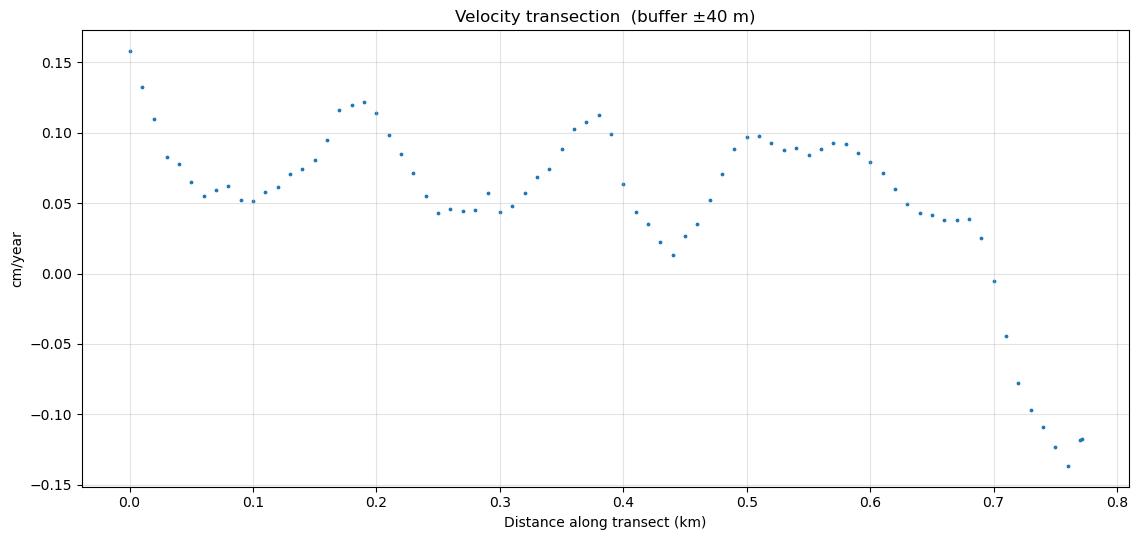

Saved CSV: /insar-data/Morandi/miaplpy2/transect_velocity.csv
Done.


In [3]:
# -*- coding: utf-8 -*-
"""
Transection (profile) of velocity along a GeoJSON LineString — MintPy-style.

Features:
- Reads velocity via mintpy.utils.readfile (2D raster).
- Gets lon/lat per pixel from geometry*.h5 (preferred) or from corner refs.
- Densifies a GeoJSON LineString at STEP_M, projects to UTM for metric sampling.
- Averages within a corridor (BUFFER_M) around each sample ("width" like plot_transection).
- Plots distance (km) vs velocity (mm/yr by default), with ±1σ shading.
- Saves CSV with per-sample stats.

Dependencies:
    pip install mintpy h5py numpy pandas geopandas shapely pyproj matplotlib
"""

from pathlib import Path
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from pyproj import CRS, Transformer
from mintpy.utils import readfile


# ===================== USER SETTINGS =====================
VEL_PATH   = Path("/insar-data/Morandi/miaplpy2/network_delaunay_4/velocity.h5")
# Optional: only used if we must reconstruct lon/lat from corner refs and velocity.h5 lacks them
TS_PATH    = Path("/insar-data/Morandi/miaplpy2/network_delaunay_4/timeseries_ERA5_demErr.h5")

# If you have a geometry file with 'longitude'/'latitude' (2D), set here; else auto-detect.
GEOMETRY_PATH = Path("/insar-data/Morandi/miaplpy2/inputs/geometryRadar.h5")   # e.g., Path("/insar-data/.../geometryGeo.h5")

LINE_GEOJSON  = Path("/insar-data/Morandi/miaplpy2/Morandi_line.geojson")

# Sampling knobs (similar to MintPy's plot_transection options)
STEP_M   = 10.0   # spacing along line in meters
BUFFER_M = 40.0     # corridor half-width in meters (0 => nearest pixel only)

# Units: many MintPy velocities are m/year — convert to mm/year for plotting if True
PLOT_MM_PER_YEAR = True

# Outputs
SAVE_FIG = Path("/insar-data/Morandi/miaplpy2/transect_velocity.png")   # set None to skip
SAVE_CSV = Path("/insar-data/Morandi/miaplpy2/transect_velocity.csv")   # set None to skip
LINEWIDTH   = 0.0
MARKER_SIZE = 3   # 0 => no markers
ALPHA_FILL  = 0.25
# ========================================================


# ------------------------- helpers -------------------------
def read_velocity(vel_path: Path):
    """Read 2D velocity and attributes via MintPy."""
    vel2d, atr = readfile.read(str(vel_path))   # default dataset in velocity.h5
    return np.asarray(vel2d, dtype=np.float32), atr

def read_lonlat_from_geometry(geom_path):
    """Read lon/lat 2D from geometry*.h5 (accepts None|str|Path)."""
    if not geom_path:
        return None, None
    p = Path(geom_path)
    if not os.path.exists(str(p)):
        return None, None

    lon = lat = None
    for name in ("longitude", "/longitude", "lon", "/lon"):
        try:
            lon, _ = readfile.read(str(p), datasetName=name);  break
        except Exception:  lon = None
    for name in ("latitude", "/latitude", "lat", "/lat"):
        try:
            lat, _ = readfile.read(str(p), datasetName=name);  break
        except Exception:  lat = None

    if lon is None or lat is None or lon.ndim != 2 or lat.ndim != 2:
        return None, None
    return np.asarray(lon, float), np.asarray(lat, float)

def lonlat_from_corner_refs(h5_path: Path, shape_rc):
    """Reconstruct lon/lat grids via bilinear interpolation from 4 corner refs."""
    _, atr = readfile.read(str(h5_path))  # attrs only
    attrs = {k.lower(): v for k, v in atr.items()}
    R, C = shape_rc
    try:
        lats = [float(attrs[f'lat_ref{i}']) for i in range(1, 5)]
        lons = [float(attrs[f'lon_ref{i}']) for i in range(1, 5)]
    except Exception as e:
        raise RuntimeError("lat_ref*/lon_ref* not found for lon/lat reconstruction.") from e

    v = np.linspace(0.0, 1.0, R)[:, None]
    u = np.linspace(0.0, 1.0, C)[None, :]

    def bilinear(c00, c10, c01, c11):
        return ((1-u)*(1-v)*c00 + u*(1-v)*c10 + (1-u)*v*c01 + u*v*c11)

    def score(LON, LAT):
        dlon = np.nanmedian(np.diff(LON, axis=1))
        dlat = np.nanmedian(np.diff(LAT, axis=0))
        flips = int(np.sum(np.sign(np.diff(LON, axis=1)) != np.sign(dlon))) \
              + int(np.sum(np.sign(np.diff(LAT, axis=0)) != np.sign(dlat)))
        dlon_dy = np.nanmedian(np.diff(LON, axis=0))
        dlat_dx = np.nanmedian(np.diff(LAT, axis=1))
        det_sign = np.sign(dlon * dlat - dlon_dy * dlat_dx)
        return (flips + (0 if det_sign != 0 else 1000), abs(dlon) + abs(dlat))

    best = None
    corners = list(zip(lons, lats))
    for perm in itertools.permutations(corners, 4):
        (lon00, lat00), (lon10, lat10), (lon01, lat01), (lon11, lat11) = perm
        LON = bilinear(lon00, lon10, lon01, lon11)
        LAT = bilinear(lat00, lat10, lat01, lat11)
        # sanity range
        if not ((min(lons)-1) <= float(np.nanmin(LON)) <= float(np.nanmax(LON)) <= (max(lons)+1)): 
            continue
        if not ((min(lats)-1) <= float(np.nanmin(LAT)) <= float(np.nanmax(LAT)) <= (max(lats)+1)):
            continue
        s = score(LON, LAT)
        if best is None or s < best[0]:
            best = (s, (LON, LAT))
    if best is None:
        raise RuntimeError("Failed to reconstruct lon/lat from corner refs.")
    return np.asarray(best[1][0]), np.asarray(best[1][1])

def get_lonlat_grid(vel_path: Path, shape_rc, geometry_path=None, ts_path: Path=None):
    """Return lon2d, lat2d (R,C). Prefer geometry*.h5; else corner refs (vel or ts)."""
    R, C = shape_rc
    geom = geometry_path
    lon2d, lat2d = read_lonlat_from_geometry(geom)
    if lon2d is not None and lat2d is not None:
        if lon2d.shape != (R, C) or lat2d.shape != (R, C):
            raise ValueError(f"geometry {geom} shape {lon2d.shape}/{lat2d.shape} != {(R,C)}")
        return lon2d, lat2d
    # fallback to corner refs
    try:
        return lonlat_from_corner_refs(vel_path, (R, C))
    except Exception:
        if ts_path and ts_path.exists():
            return lonlat_from_corner_refs(ts_path, (R, C))
        raise

def pick_linestring_from_geojson(gpath: Path) -> LineString:
    """Load GeoJSON and return the longest LineString in WGS84."""
    gdf = gpd.read_file(gpath)
    if gdf.crs is None: gdf = gdf.set_crs(4326)
    else: gdf = gdf.to_crs(4326)
    lines = []
    for geom in gdf.geometry:
        if geom is None: continue
        if isinstance(geom, LineString):
            lines.append(geom)
        elif isinstance(geom, MultiLineString):
            lines.extend(list(geom.geoms))
    if not lines:
        raise ValueError("GeoJSON must contain a LineString or MultiLineString.")
    # choose longest
    lengths = [ln.length for ln in lines]
    return lines[int(np.argmax(lengths))]

def utm_crs_for_lonlat(lon_deg: float, lat_deg: float) -> CRS:
    zone = int((lon_deg + 180) // 6) + 1
    epsg = 32600 + zone if lat_deg >= 0 else 32700 + zone
    return CRS.from_epsg(epsg)

def densify_line_wgs84(ls: LineString, step_m: float) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return distances (m) and lon/lat at fixed spacing along the WGS84 line."""
    c = ls.centroid
    crs_wgs84 = CRS.from_epsg(4326)
    crs_utm = utm_crs_for_lonlat(c.x, c.y)
    to_utm = Transformer.from_crs(crs_wgs84, crs_utm, always_xy=True)
    to_wgs = Transformer.from_crs(crs_utm, crs_wgs84, always_xy=True)
    xs, ys = to_utm.transform(*ls.coords.xy)
    ls_utm = LineString(np.column_stack([xs, ys]))
    total = ls_utm.length
    if total == 0:
        raise ValueError("LineString has zero length.")
    dists = np.arange(0.0, total + step_m, step_m)
    if dists[-1] > total: dists[-1] = total
    pts = [ls_utm.interpolate(d) for d in dists]
    px = np.array([p.x for p in pts]); py = np.array([p.y for p in pts])
    lon, lat = to_wgs.transform(px, py)
    return dists, np.asarray(lon), np.asarray(lat)

def sample_transect(lon2d, lat2d, raster2d, sample_lon, sample_lat, buffer_m: float):
    """
    For each sample point, average raster values of pixels whose centers fall within buffer_m.
    Buffer distance computed in a local UTM (per-point).
    Returns mean, std, count arrays.
    """
    # Precompute pixel centers in WGS84 (flattened)
    flat_lon = lon2d.ravel()
    flat_lat = lat2d.ravel()
    flat_val = raster2d.ravel()
    Npix = flat_lon.size

    means = np.full(sample_lon.size, np.nan, dtype=np.float32)
    stds  = np.full(sample_lon.size, np.nan, dtype=np.float32)
    counts= np.zeros(sample_lon.size, dtype=np.int32)

    # If buffer is zero, do nearest pixel only (fast)
    if not buffer_m or buffer_m <= 0:
        for i, (lo, la) in enumerate(zip(sample_lon, sample_lat)):
            d2 = (flat_lon - lo)**2 + (flat_lat - la)**2
            j = int(np.nanargmin(d2))
            v = flat_val[j]
            if np.isfinite(v):
                means[i] = v; stds[i] = 0.0; counts[i] = 1
        return means, stds, counts

    # With buffer: do per-sample local UTM projection and radial select
    for i, (lo, la) in enumerate(zip(sample_lon, sample_lat)):
        # Build local UTM at this sample
        crs_utm = utm_crs_for_lonlat(lo, la)
        to_utm = Transformer.from_crs(CRS.from_epsg(4326), crs_utm, always_xy=True)
        sx, sy = to_utm.transform(lo, la)
        px, py = to_utm.transform(flat_lon, flat_lat)
        dx = px - sx; dy = py - sy
        mask = (dx*dx + dy*dy) <= (buffer_m * buffer_m)
        if not np.any(mask):
            continue
        vals = flat_val[mask]
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            continue
        means[i]  = np.nanmean(vals)
        stds[i]   = np.nanstd(vals)
        counts[i] = vals.size

    return means, stds, counts
# ----------------------------------------------------------


def main():
    # 1) read raster
    vel2d, vatr = read_velocity(VEL_PATH)
    R, C = vel2d.shape

    # 2) lon/lat per pixel
    lon2d, lat2d = get_lonlat_grid(
        VEL_PATH, (R, C),
        geometry_path=GEOMETRY_PATH,
        ts_path=TS_PATH if TS_PATH.exists() else None
    )

    # 3) load/densify transect
    line = pick_linestring_from_geojson(LINE_GEOJSON)
    dist_m, sam_lon, sam_lat = densify_line_wgs84(line, STEP_M)

    # 4) sample with optional buffer (corridor)
    mean_vals, std_vals, counts = sample_transect(
        lon2d, lat2d, vel2d, sam_lon, sam_lat, BUFFER_M
    )

    # 5) units
    unit_attr = (vatr.get("UNIT") or vatr.get("UNITS") or vatr.get("unit") or "").lower()
    y_mean = mean_vals.copy()
    y_std  = std_vals.copy()
    y_label = unit_attr if unit_attr else "velocity"
    if PLOT_MM_PER_YEAR:
        # typical MintPy velocity unit is m/year
        if "m" in unit_attr and "mm" not in unit_attr:
            y_mean *= 100.0
            y_std  *= 100.0
            if "year" in unit_attr or "/yr" in unit_attr or "yr" in unit_attr:
                y_label = "cm/year"
            else:
                y_label = "cm"
        else:
            # assume already mm/yr or unknown
            if "year" in unit_attr or "/yr" in unit_attr or "yr" in unit_attr:
                y_label = "mm/year"
            else:
                y_label = "mm"

    # 6) plotting (MintPy-style: mean with ±1σ shading)
    x_km = dist_m / 1000.0
    ok = np.isfinite(y_mean)
    plt.figure(figsize=(11.5, 5.5))
    if np.any(ok):
        #plt.fill_between(x_km[ok], (y_mean - y_std)[ok], (y_mean + y_std)[ok], alpha=ALPHA_FILL, linewidth=0)
        #plt.plot(x_km[ok], y_mean[ok], linewidth=LINEWIDTH)
        if MARKER_SIZE > 0:
            plt.scatter(x_km[ok], y_mean[ok], s=MARKER_SIZE)
    plt.xlabel("Distance along transect (km)")
    plt.ylabel(y_label)
    title_units = f"  (buffer ±{BUFFER_M:.0f} m)" if BUFFER_M and BUFFER_M > 0 else "  (nearest pixel)"
    plt.title(f"Velocity transection{title_units}")
    plt.grid(True, alpha=0.35)
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(SAVE_FIG, dpi=200)
        print(f"Saved figure: {SAVE_FIG}")
    plt.show()

    # 7) CSV export
    if SAVE_CSV:
        out = pd.DataFrame({
            "distance_m": dist_m,
            "lon": sam_lon,
            "lat": sam_lat,
            "count": counts,
            "vel_native": mean_vals,          # native unit from file
            "vel_native_std": std_vals,
            "vel_plotted": y_mean,            # possibly in mm/yr
            "vel_plotted_std": y_std,
        })
        out.to_csv(SAVE_CSV, index=False)
        print(f"Saved CSV: {SAVE_CSV}")

    print("Done.")


if __name__ == "__main__":
    main()

